In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_text
from sklearn.tree import plot_tree

In [2]:
df = pd.read_csv("ksi_collisions.csv")

In [3]:
df.sample(2)

,DATE,STREET1,STREET2,DISTRICT,LATITUDE,LONGITUDE,VISIBILITY,LIGHT,ROAD_CONDITION,ACCLASS,...,DOW,HOUR,YEAR,MONTH,SEVERE_COLLISION,TIME_OF_DAY,SEASON,VEHICLE_TYPE,DRIVER_ACTION,IMPACT_TYPE
14376,2018-05-10,EASTERN AVE,COXWELL AVE,Toronto and East York,43.665419,-79.31618,Clear,Daylight,Dry,Non-Fatal Injury,...,Thursday,18,2018,5,0,Evening,Spring,Car,Right-of-Way/Traffic Violation,T-Bone
6039,2010-07-13,EGLINTON Ave E,LAIRD Dr,North York,43.713545,-79.36479,Clear,Daylight,Dry,Non-Fatal Injury,...,Tuesday,18,2010,7,0,Evening,Summer,Car,Control/Maneuver Error,Rear End


In [4]:
categorical_features = ['LIGHT', 'VISIBILITY', 'ROAD_CONDITION', 'DOW', 'TIME_OF_DAY', 'SEASON', 'VEHICLE_TYPE', 'DRIVER_ACTION', 'IMPACT_TYPE']

In [5]:
target = 'SEVERE_COLLISION'

In [6]:
X = df[categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=65,
        max_depth=9,
        max_features = 'sqrt',
        random_state=42,
        n_jobs=-1
    ))
])

In [34]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [35]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.69      0.70      2021
           1       0.65      0.67      0.66      1725

    accuracy                           0.68      3746
   macro avg       0.68      0.68      0.68      3746
weighted avg       0.68      0.68      0.68      3746



In [36]:
model.score(X_test, y_test)

0.6793913507741591

In [11]:
sample = {
    'LIGHT': 'Daylight',
    'VISIBILITY': 'Clear',
    'ROAD_CONDITION': 'Dry',
    'DOW': 'Friday',
    'TIME_OF_DAY': 'Evening',
    'SEASON': 'S',
    'VEHICLE_TYPE': 'Car',
    'DRIVER_ACTION': 'Failed to Yield Right of Way',
    'IMPACT_TYPE': 'T-Bone'
}

sample_df = pd.DataFrame([sample])

In [12]:
prediction = model.predict(sample_df)[0]
probability = model.predict_proba(sample_df)[0][1]
print(f"Predicted class: {prediction} (1 = Severe, 0 = Not Severe)")
print(f"Probability of severe collision: {probability:.3f}")

Predicted class: 0 (1 = Severe, 0 = Not Severe)
Probability of severe collision: 0.393


In [13]:
y_proba = model.predict_proba(df)[:, 1]

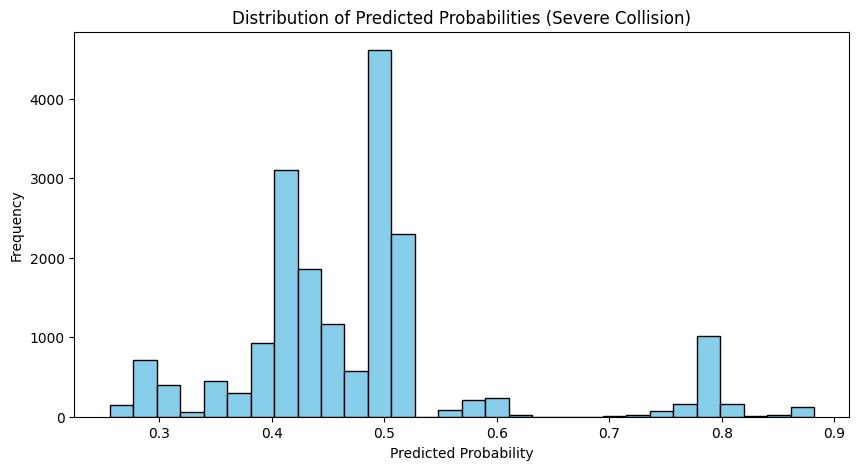

In [14]:
plt.figure(figsize=(10,5))
plt.hist(y_proba, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Predicted Probabilities (Severe Collision)")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.show()

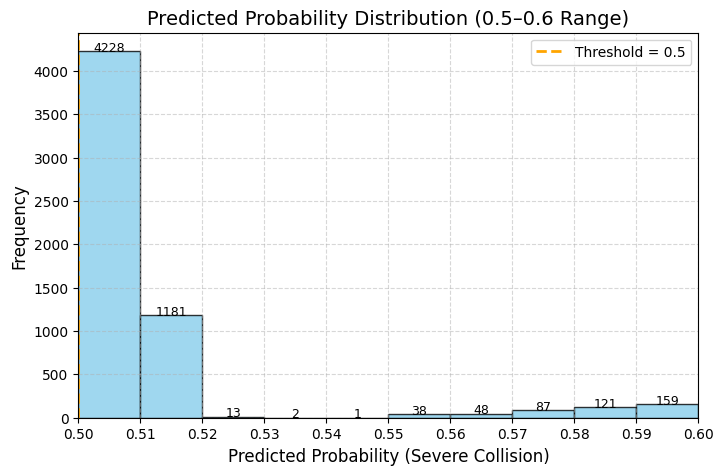

In [17]:
bins = np.arange(0.5, 0.61, 0.01)

plt.figure(figsize=(8,5))
counts, bins, patches = plt.hist(
    y_proba, bins=bins, color='skyblue', edgecolor='black', alpha=0.8
)

plt.title("Predicted Probability Distribution (0.5–0.6 Range)", fontsize=14)
plt.xlabel("Predicted Probability (Severe Collision)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

for i, count in enumerate(counts):
    plt.text(bins[i] + 0.005, count + 0.5, str(int(count)), ha='center', fontsize=9)

plt.axvline(0.5, color='orange', linestyle='--', linewidth=2, label='Threshold = 0.5')

plt.xlim(0.5, 0.6)
plt.xticks(np.arange(0.5, 0.61, 0.01))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()